In [39]:
# Importing Libraires and dependencies :
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,LSTM,Dropout
import yfinance as yf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import zscore
import joblib

In [40]:
data = yf.download("^GSPC")[["Close","Volume"]]

[*********************100%%**********************]  1 of 1 completed


In [41]:
data = data[10000:].pct_change().dropna()

In [42]:
data["close_z"] = zscore(data["Close"])
data["vol_z"] = zscore(data["Volume"])

In [15]:
# start_time = dt.datetime.now().date() -dt.timedelta(days=100)
# data = yf.download("^GSPC",start=start_time)[["Close","Volume"]]
# input_scaler = joblib.load("./model_components/x_scaler.joblib")
# output_scaler = joblib.load("./model_components/y_scaler.joblib")
# model = load_model("./model_components/lstm.h5")
# input_scaled = input_scaler.transform(data.iloc[-60:, :]).reshape((1,60,2))
# pred = model.predict(input_scaled)

In [46]:
def window_data(data,look_back,foresact):
    X= []
    y=[]
    for i in range(len(data)-look_back - foresact + 1):
        features = data.iloc[i:(i+look_back), :]
        target = data.iloc[(i+look_back): (i + look_back + foresact),0]
        X.append(features)
        y.append(target)
    return np.array(X),np.array(y)

In [47]:
X,y = window_data(data, look_back=60, foresact=5)

In [48]:
X.shape,y.shape

((14123, 60, 4), (14123, 5))

In [49]:
split = int(0.7*len(data))
x_train =X[:split]
x_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [81]:
model = Sequential()
model.add(LSTM(50,return_sequences=True ,input_shape = (x_train.shape[1],x_train.shape[2]),activation ='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=True,activation ='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=True,activation ='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(50,activation ='tanh'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='linear')) 
model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error')

In [82]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 60, 50)            11000     
                                                                 
 dropout_24 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_25 (LSTM)              (None, 60, 100)           60400     
                                                                 
 dropout_25 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_26 (LSTM)              (None, 60, 100)           80400     
                                                                 
 dropout_26 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_27 (LSTM)              (None, 50)               

In [83]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=5,         
    restore_best_weights=True)

In [84]:
history = model.fit(x_train,y_train,batch_size=50,epochs=100,validation_split=0.2,shuffle=False, callbacks=[early_stopping_callback])

Epoch 1/100
159/159 [==============================] - 9s 30ms/step - loss: 1.0367e-04 - val_loss: 1.2589e-04
Epoch 2/100
159/159 [==============================] - 4s 23ms/step - loss: 9.3212e-05 - val_loss: 1.2621e-04
Epoch 3/100
159/159 [==============================] - 4s 24ms/step - loss: 9.0783e-05 - val_loss: 1.2497e-04
Epoch 4/100
159/159 [==============================] - 4s 25ms/step - loss: 8.9882e-05 - val_loss: 1.2484e-04
Epoch 5/100
159/159 [==============================] - 4s 26ms/step - loss: 8.9233e-05 - val_loss: 1.2474e-04
Epoch 6/100
159/159 [==============================] - 4s 26ms/step - loss: 8.8752e-05 - val_loss: 1.2475e-04
Epoch 7/100
159/159 [==============================] - 4s 27ms/step - loss: 8.8588e-05 - val_loss: 1.2474e-04
Epoch 8/100
159/159 [==============================] - 4s 27ms/step - loss: 8.8475e-05 - val_loss: 1.2469e-04
Epoch 9/100
159/159 [==============================] - 4s 26ms/step - loss: 8.8447e-05 - val_loss: 1.2447e-04
Epoch 10/1

In [85]:
model.evaluate(x_test,y_test)

132/132 [==============================] - 1s 10ms/step - loss: 1.6504e-04


0.000165038465638645

In [86]:
predictions = model.predict(x_test)

132/132 [==============================] - 2s 10ms/step


In [87]:
predictions[-1]

array([0.00106819, 0.0009089 , 0.0012117 , 0.0011884 , 0.00113906],
      dtype=float32)

In [88]:
from sklearn.metrics import mean_squared_error

In [89]:
error = []
for i,x  in zip(y_test,predictions):
    epsilon = mean_squared_error(i*100,x*100)
    error.append(epsilon)
sum(error) / len(error)

1.6503848819289988

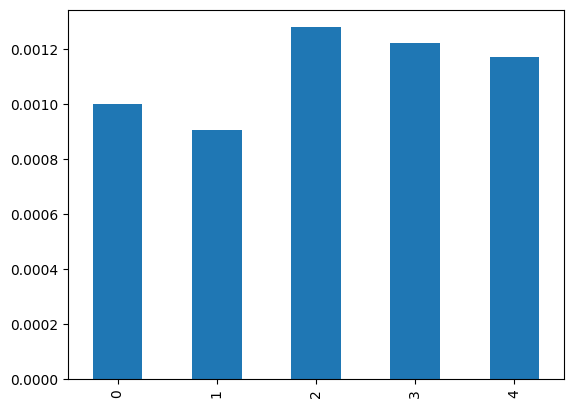

In [100]:
pd.Series(predictions[-5]).plot(kind = "bar")
# pd.Series(y_test[-1]).plot()
plt.show();

<Axes: >

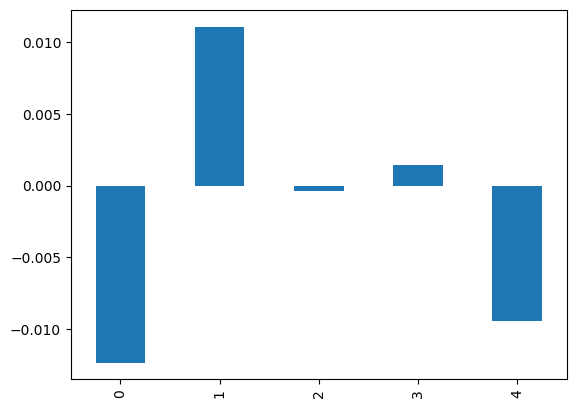

In [101]:
pd.Series(y_test[-5]).plot(kind="bar")

In [95]:
model.save("lstm.h5")

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
loaded_model = load_model("lstm.h5")